In [1]:
import os
import sys

src_dir = "/run/media/sahilsasane/Disk_1/Sahil/TMDC/test_repo/travel-agent/src"
sys.path.insert(0, src_dir)

In [ ]:
from typing import Annotated, Literal, Optional

from langchain_core.messages import AIMessage, SystemMessage
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnableSerializable
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from tools.car_rental_tools import (
    BookCarRental,
    CancelCarRental,
    SearchCarRental,
    UpdateCarRental,
)
from tools.flight_tools import (
    BookFlight,
    CancelFlight,
    # FetchFlightDetails,
    SearchFlights,
    UpdateFlight,
    fetch_user_flight_information,
)
from tools.hotel_tools import (
    BookHotel,
    CancelHotelBooking,
    SearchHotel,
    UpdateHotelBooking,
)
from tools.taxi_tools import (
    BookTaxi,
    SearchTaxi,
)
from tools.trip_recommendations import (
    book_trip,
    cancel_trip,
    search_trip_recommendations,
    update_trip,
)
from typing_extensions import TypedDict

from agents.llama_guard import LlamaGuard, LlamaGuardOutput, SafetyAssessment


In [3]:
# db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"

In [4]:
# Tool Error Handling
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)  # Tool Error Handling


In [5]:
def update_dialog_stack(left: list[str], right: str | None) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    safety: LlamaGuardOutput
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "update_flight",
                "book_flight",
                "search_flight",
                "cancel_flight",
                "book_car_rental",
                "book_hotel",
                "book_trip",
                "book_taxi",
            ]
        ],
        update_dialog_stack,
    ]


In [6]:
from datetime import datetime

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from pydantic import BaseModel, Field

# llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", temperature=1)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            # llama_guard = LlamaGuard()
            # safety_output = await llama_guard.ainvoke("Agent", state["messages"] + [result])

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [7]:
class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

In [8]:
# Flight booking assistant

flight_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling flight bookings, updates and cancellations. "
            "The primary assistant delegates work to you whenever the user needs help with flight-related tasks. "
            "You can search for flights, book new flights, update existing bookings, and cancel flights."
            "When booking flights, confirm all details with the customer before proceeding. "
            "Confirm the updated flight details with the customer and inform them of any additional fees. "
            "When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant. "
            "Remember that a booking isn't completed until after the relevant tool has successfully been used. "
            "You have access to the following tools: SearchFlights, BookFlight, UpdateFlight, and CancelFlight."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

# Define tool categories
update_flight_safe_tools = [SearchFlights(), UpdateFlight(), CancelFlight(), BookFlight()]
update_flight_sensitive_tools = []
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools

# Create the runnable with all tools
update_flight_runnable = flight_booking_prompt | llm.bind_tools(
    update_flight_tools + [CompleteOrEscalate]
)

In [9]:
# Hotel Booking Assistant
book_hotel_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling hotel bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a hotel. "
            "Search for available hotels based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant.'
            " Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Hotel booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_hotel_safe_tools = [SearchHotel(), BookHotel(), UpdateHotelBooking(), CancelHotelBooking()]
book_hotel_sensitive_tools = []
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(book_hotel_tools + [CompleteOrEscalate])

In [10]:
# Car Rental Assistant
book_car_rental_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling car rental bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a car rental. "
            "Search for available car rentals based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'What flights are available?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Car rental booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_car_rental_safe_tools = [
    SearchCarRental(),
    BookCarRental(),
    UpdateCarRental(),
    CancelCarRental(),
]
book_car_rental_sensitive_tools = []
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(
    book_car_rental_tools + [CompleteOrEscalate]
)

In [11]:
# Taxi Booking Assistant
taxi_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling taxi bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a taxi. "
            "Format your responses properly."
            "Search for available taxis based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'What flights are available?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Car rental booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

taxi_booking_safe_tools = [SearchTaxi(), BookTaxi()]
taxi_booking_sensitive_tools = []
taxi_booking_tools = taxi_booking_safe_tools + taxi_booking_sensitive_tools
taxi_booking_runnable = taxi_booking_prompt | llm.bind_tools(
    taxi_booking_tools + [CompleteOrEscalate]
)

In [12]:
book_trip_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling trip recommendations. "
            "The primary assistant delegates work to you whenever the user needs help booking a recommended trip. "
            "Search for available trip recommendations based on the user's preferences and confirm the booking details with the customer. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Trip booking confirmed!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_trip_safe_tools = [search_trip_recommendations, book_trip, update_trip, cancel_trip]
book_trip_sensitive_tools = []
book_trip_tools = book_trip_safe_tools + book_trip_sensitive_tools
book_trip_runnable = book_trip_prompt | llm.bind_tools(book_trip_tools + [CompleteOrEscalate])

In [13]:
# Primary Assistant
class ToFlightBookingAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle flight updates and cancellations."""

    request: str = Field(
        description="Any necessary followup questions the update flight assistant should clarify before proceeding."
    )


class ToBookCarRental(BaseModel):
    """Transfers work to a specialized assistant to handle car rental bookings."""

    # location: str = Field(description="The location where the user wants to rent a car.")
    # start_date: str = Field(description="The start date of the car rental.")
    # end_date: str = Field(description="The end date of the car rental.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the car rental."
    )


class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    # location: str = Field(description="The location where the user wants to book a hotel.")
    # checkin_date: str = Field(description="The check-in date for the hotel.")
    # checkout_date: str = Field(description="The check-out date for the hotel.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )


class ToTaxiBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle taxi bookings."""

    # pickup_location: str = Field(description="The location where the user wants to be picked up.")
    # dropoff_location: str = Field(
    #     description="The location where the user wants to be dropped off."
    # )
    # pickup_time: str = Field(description="The time when the user wants to be picked up.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the taxi booking."
    )


class ToTripBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle trip bookings."""

    # destination: str = Field(description="The destination for the trip.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the trip booking."
    )

In [14]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful travel assistant."
            "Your primary role is to search for flight information and company policies to answer customer queries. "
            "If a customer requests to book a new flight, update or cancel a flight, book a car rental, book a hotel, or get trip recommendations, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "For flight-related tasks (booking new flights, updating existing bookings, or cancellations), use ToFlightBookingAssistant. "
            "For car rentals, use ToBookCarRental. For hotel bookings, use ToHotelBookingAssistant. "
            "For taxi bookings, use ToTaxiBookingAssistant. "
            "For trip recommendations, use ToTripBookingAssistant."
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

primary_assistant_tools = [
    TavilySearch(max_results=1),
    # fetch_user_flight_information,
]

assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToFlightBookingAssistant,
        ToBookCarRental,
        ToHotelBookingAssistant,
        ToTaxiBookingAssistant,
        ToTripBookingAssistant,
    ]
)

In [15]:
from collections.abc import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

In [16]:
def format_safety_message(safety: LlamaGuardOutput) -> AIMessage:
    content = (
        f"This conversation was flagged for unsafe content: {', '.join(safety.unsafe_categories)}"
    )
    return AIMessage(content=content)


async def llama_guard_input(state: State, config: RunnableConfig) -> State:
    llama_guard = LlamaGuard()
    safety_output = await llama_guard.ainvoke("User", state["messages"])
    return {"safety": safety_output, "messages": []}


async def block_unsafe_content(state: State, config: RunnableConfig) -> State:
    safety: LlamaGuardOutput = state["safety"]
    return {"messages": [format_safety_message(safety)]}


def check_safety(state: State) -> Literal["unsafe", "safe"]:
    safety: LlamaGuardOutput = state["safety"]
    match safety.safety_assessment:
        case SafetyAssessment.UNSAFE:
            return "unsafe"
        case _:
            return "safe"

In [17]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_node("guard_input", llama_guard_input)
builder.add_node("block_unsafe_content", block_unsafe_content)

builder.set_entry_point("guard_input")
builder.add_conditional_edges(
    "guard_input", check_safety, {"unsafe": "block_unsafe_content", "safe": "fetch_user_info"}
)
builder.add_edge("block_unsafe_content", END)

In [18]:
builder.add_node(
    "enter_update_flight",
    create_entry_node("Flight Updates & Booking Assistant", "update_flight"),
)
builder.add_node("update_flight", Assistant(update_flight_runnable))
builder.add_edge("enter_update_flight", "update_flight")

# Tool execution nodes
builder.add_node(
    "update_flight_sensitive_tools",
    create_tool_node_with_fallback(update_flight_sensitive_tools),
)
builder.add_node(
    "update_flight_safe_tools",
    create_tool_node_with_fallback(update_flight_safe_tools),
)


def route_update_flight(state: State):
    """Route to appropriate tool execution based on the tools called."""
    route = tools_condition(state)
    if route == END:
        return END

    tool_calls = state["messages"][-1].tool_calls
    if not tool_calls:
        return END

    # Check if CompleteOrEscalate was called
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"

    # Determine if all tools are safe tools
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    else:
        # Any sensitive tool (including BookFlight) goes here
        return "update_flight_sensitive_tools"


# Add edges for tool execution
builder.add_edge("update_flight_sensitive_tools", "update_flight")
builder.add_edge("update_flight_safe_tools", "update_flight")

# Add conditional routing
builder.add_conditional_edges(
    "update_flight",
    route_update_flight,
    ["update_flight_sensitive_tools", "update_flight_safe_tools", "leave_skill", END],
)


def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.
    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [19]:
# Car rental assistant

builder.add_node(
    "enter_book_car_rental",
    create_entry_node("Car Rental Assistant", "book_car_rental"),
)
builder.add_node("book_car_rental", Assistant(book_car_rental_runnable))
builder.add_edge("enter_book_car_rental", "book_car_rental")
builder.add_node(
    "book_car_rental_safe_tools",
    create_tool_node_with_fallback(book_car_rental_safe_tools),
)
builder.add_node(
    "book_car_rental_sensitive_tools",
    create_tool_node_with_fallback(book_car_rental_sensitive_tools),
)


def route_book_car_rental(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in book_car_rental_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_car_rental_safe_tools"
    return "book_car_rental_sensitive_tools"


builder.add_edge("book_car_rental_sensitive_tools", "book_car_rental")
builder.add_edge("book_car_rental_safe_tools", "book_car_rental")
builder.add_conditional_edges(
    "book_car_rental",
    route_book_car_rental,
    [
        "book_car_rental_safe_tools",
        "book_car_rental_sensitive_tools",
        "leave_skill",
        END,
    ],
)

In [20]:
# Taxi Booking assistant
builder.add_node(
    "enter_book_taxi",
    create_entry_node("Taxi Booking Assistant", "book_taxi"),
)
builder.add_node("book_taxi", Assistant(taxi_booking_runnable))
builder.add_edge("enter_book_taxi", "book_taxi")
builder.add_node(
    "book_taxi_safe_tools",
    create_tool_node_with_fallback(taxi_booking_safe_tools),
)
builder.add_node(
    "book_taxi_sensitive_tools",
    create_tool_node_with_fallback(taxi_booking_sensitive_tools),
)


def route_book_taxi(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in taxi_booking_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_taxi_safe_tools"
    return "book_taxi_sensitive_tools"


builder.add_edge("book_taxi_sensitive_tools", "book_taxi")
builder.add_edge("book_taxi_safe_tools", "book_taxi")
builder.add_conditional_edges(
    "book_taxi",
    route_book_taxi,
    [
        "book_taxi_safe_tools",
        "book_taxi_sensitive_tools",
        "leave_skill",
        END,
    ],
)

In [21]:
# Trip Booking assistant
builder.add_node(
    "enter_book_trip",
    create_entry_node("Taxi Booking Assistant", "book_trip"),
)
builder.add_node("book_trip", Assistant(book_trip_runnable))
builder.add_edge("enter_book_trip", "book_trip")
builder.add_node(
    "book_trip_safe_tools",
    create_tool_node_with_fallback(book_trip_safe_tools),
)
builder.add_node(
    "book_trip_sensitive_tools",
    create_tool_node_with_fallback(book_trip_sensitive_tools),
)


def route_book_trip(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in book_trip_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_trip_safe_tools"
    return "book_trip_sensitive_tools"


builder.add_edge("book_trip_sensitive_tools", "book_trip")
builder.add_edge("book_trip_safe_tools", "book_trip")
builder.add_conditional_edges(
    "book_trip",
    route_book_trip,
    [
        "book_trip_safe_tools",
        "book_trip_sensitive_tools",
        "leave_skill",
        END,
    ],
)

In [22]:
# Hotel booking assistant
builder.add_node("enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel"))
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_node(
    "book_hotel_safe_tools",
    create_tool_node_with_fallback(book_hotel_safe_tools),
)
builder.add_node(
    "book_hotel_sensitive_tools",
    create_tool_node_with_fallback(book_hotel_sensitive_tools),
)


def route_book_hotel(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


builder.add_edge("book_hotel_sensitive_tools", "book_hotel")
builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_conditional_edges(
    "book_hotel",
    route_book_hotel,
    ["leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", END],
)

In [23]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node("primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools))


def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToFlightBookingAssistant.__name__:
            return "enter_update_flight"
        elif tool_calls[0]["name"] == ToBookCarRental.__name__:
            return "enter_book_car_rental"
        elif tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        elif tool_calls[0]["name"] == ToTaxiBookingAssistant.__name__:
            return "enter_book_taxi"
        elif tool_calls[0]["name"] == ToTripBookingAssistant.__name__:
            return "enter_book_trip"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_update_flight",
        "enter_book_car_rental",
        "enter_book_hotel",
        "enter_book_taxi",
        "enter_book_trip",
        "primary_assistant_tools",
        END,
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant", "update_flight", "book_car_rental", "book_hotel", "book_taxi", "book_trip"
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = MemorySaver()
workflow = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "update_flight_sensitive_tools",
        "book_car_rental_sensitive_tools",
        "book_hotel_sensitive_tools",
        "book_taxi_sensitive_tools",
        "book_trip_sensitive_tools",
    ],
)

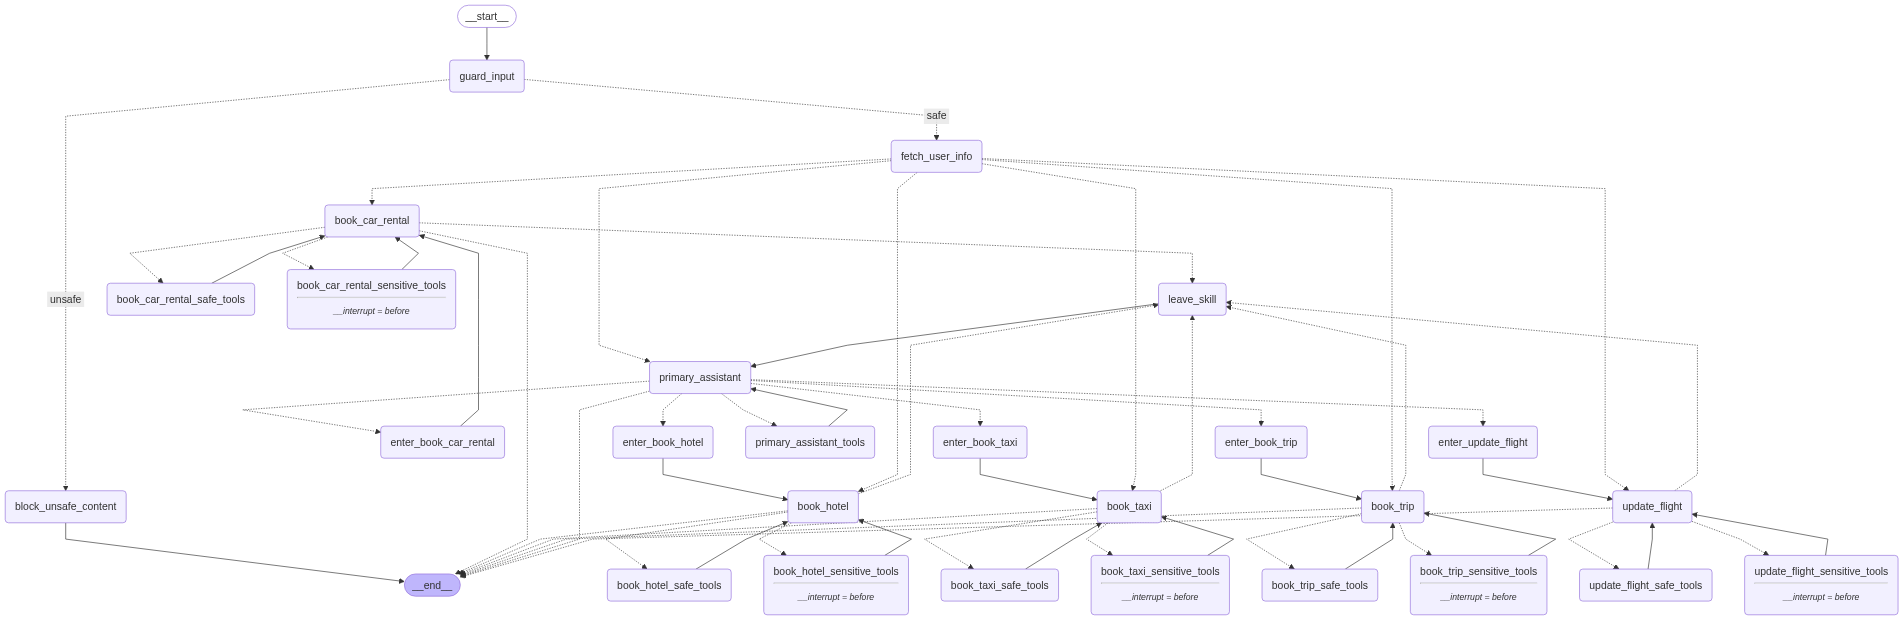

In [24]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "passenger_id": "8149 123456",
        "thread_id": thread_id,
    }
}

_printed = set()

In [ ]:
await workflow.ainvoke(
    {
        "messages": (
            "user",
            "",
        )
    },
    config,
    stream_mode="values",
)

#### Evaluation

In [25]:
from langfuse import Langfuse
from langfuse.langchain import CallbackHandler

langfuse = Langfuse(
    public_key="pk-lf-c7be1653-c7b1-4136-90e9-6132b375e823",
    secret_key="sk-lf-dc2be4ce-811a-46b5-a385-7bbe1ab307b8",
    host="http://localhost:3000",
)

langfuse_handler = CallbackHandler()

In [55]:
langfuse.create_dataset(name="travel_agent_trajectory")

Dataset(id='cmc1p6tcn0088p007sty1mhu0', name='travel_agent_trajectory', description=None, metadata=None, project_id='cmbzo5qbe0006p007gzctcxsr', created_at=datetime.datetime(2025, 6, 18, 8, 36, 12, 695000, tzinfo=datetime.timezone.utc), updated_at=datetime.datetime(2025, 6, 18, 8, 36, 12, 695000, tzinfo=datetime.timezone.utc))

In [56]:
local_items = [
    # Primary assistant has user info
    {
        "input": {"question": "Hi what time is my flight"},
        "expected_output": {
            "response": """You have two flights scheduled:
            Flight SU0022 from MSP to GVA on 2025-06-11 at 22:21:22.037749-04:00.
            Flight IB0093 from LIS to BOM on 2025-06-30 at 13:01:22.037749-04:00.
            """,
            "trajectory": ["fetch_user_info", "primary_assistant"],
        },
    },
    {
        "input": {"question": "what are my hotel bookings"},
        "expected_output": {
            "response": """You have two hotel bookings:

            Booking ID: 7AE0A724
                Check-in Date: 2025-06-16
                Check-out Date: 2025-06-23
                Number of Guests: 1

            Booking ID: D295F2FF
                Check-in Date: 2025-06-16
                Check-out Date: 2025-06-23
                Number of Guests: 1

            """,
            "trajectory": ["fetch_user_info", "primary_assistant"],
        },
    },
    {
        "input": {"question": "what are my taxi bookings"},
        "expected_output": {
            "response": """
            You have one taxi booking:
                Pickup Time: 17:00
                Pickup Location: Zurich
                Dropoff Location: Basel
            """,
            "trajectory": ["fetch_user_info", "primary_assistant"],
        },
    },
    # Routing tasks by the agent - checking trajectory of tool calls
    {
        "input": {"question": "can you help me book a flight"},
        "expected_output": {
            "response": """
            I can help with that! To book a flight, I need a few details. Could you please tell me:
            Where would you like to depart from? (Departure airport)
            Where would you like to go? (Arrival airport)
            What is your desired departure date?
            How many passengers will be traveling?
            """,
            "trajectory": ["fetch_user_info", "primary_assistant"],
        },
    },
    {
        "input": {"question": "can you help me book a car rental"},
        "expected_output": {
            "response": """I can help you with that. To book a car rental, I need to know the following information:
            What are your desired pick-up and drop-off dates?
            What is the pick-up location?
            """,
            "trajectory": [
                "fetch_user_info",
                "primary_assistant",
                "enter_book_car_rental",
                "book_car_rental",
            ],
        },
    },
    {
        "input": {"question": "can you help me book a hotel"},
        "expected_output": {
            "response": """I can definitely help you book a hotel! To start, what location are you interested in? Do you have a specific hotel name in mind, or a preferred price range (like Midscale, Upscale, Luxury)?
            """,
            "trajectory": [
                "fetch_user_info",
                "primary_assistant",
                "enter_book_hotel",
                "book_hotel",
            ],
        },
    },
    {
        "input": {"question": "can you help me book a taxi"},
        "expected_output": {
            "response": """I can help you book a taxi. To do that, I need a few details:
                What is your pickup location?
                What is your drop-off location?
                What time would you like to be picked up?
                How many passengers will there be?
            Do you have any preferences for the vehicle type (e.g., sedan, SUV) or price tier (e.g., standard, premium)?
            """,
            "trajectory": ["fetch_user_info", "primary_assistant", "enter_book_taxi", "book_taxi"],
        },
    },
]

In [57]:
# Upload to Langfuse
for item in local_items:
    langfuse.create_dataset_item(
        dataset_name="travel_agent_trajectory",
        # any python object or value
        input=item["input"],
        # any python object or value, optional
        expected_output=item["expected_output"],
    )

In [96]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


def run_workflow(input, callback_handler):
    config = {
        "configurable": {
            "passenger_id": "8149 123456",
            "thread_id": thread_id,
        },
        "callbacks": [callback_handler],
    }
    res = workflow.invoke({"messages": [HumanMessage(content=input)]}, config=config)

    return res

In [97]:
judge_llm = llm


async def llm_as_judge_eval(outputs, expected_output):
    instructions = (
        "Given an actual answer and an expected answer, determine how well"
        " the actual answer contains all of the information in the expected answer."
        " Respond with a score from 0 to 1, where 1 means the actual answer contains"
        " all expected information, and 0 means it contains none. Do not include anything else in your response."
    )

    actual_answer = outputs["messages"][-1].content
    user_msg = f"ACTUAL_ANSWER: {actual_answer}\nEXPECTED_ANSWER: {expected_output}"
    response = await judge_llm.ainvoke(
        [
            {
                "role": "system",
                "content": instructions,
            },
            {
                "role": "user",
                "content": user_msg,
            },
        ]
    )
    print(response.content, type(response.content))
    return response.content

In [98]:
from langfuse.langchain import CallbackHandler


def run_langchain_experiment(experiment_name):
    dataset = langfuse.get_dataset("travel_agent")

    # Initialize the Langfuse handler
    langfuse_handler = CallbackHandler()

    for item in dataset.items:
        # Use the item.run() context manager
        with item.run(
            run_name=experiment_name,
        ) as root_span:  # root_span is the root span of the new trace for this item and run.
            # All subsequent langfuse operations within this block are part of this trace.

            # Call your application logic
            output = run_workflow(item.input["question"], langfuse_handler)
            # print(output)

            # Optionally, score the result against the expected output
            # root_span.score_trace(
            #     name="judge_llm",
            #     value=llm_as_judge_eval(output, item.expected_output),
            # )

    print(f"\nFinished processing dataset 'travel_agent' for run '{experiment_name}'.")

In [ ]:
run_langchain_experiment("travel_agent_test_experiment")

#### Trajectory Evaluation

In [58]:
def trajectory_subsequence(outputs: dict, reference_outputs: dict) -> float:
    """Check how many of the desired steps the agent took."""
    if len(reference_outputs["trajectory"]) > len(outputs["trajectory"]):
        return False

    i = j = 0
    while i < len(reference_outputs["trajectory"]) and j < len(outputs["trajectory"]):
        if reference_outputs["trajectory"][i] == outputs["trajectory"][j]:
            i += 1
        j += 1
    length = len(reference_outputs["trajectory"])
    return i / length if length > 0 else 1.0

In [ ]:
def run_graph_trajectory(inputs: dict, callback_handler) -> dict:
    """Run graph and track the trajectory it takes along with the final response."""
    trajectory = []
    thread_id = str(uuid.uuid4())
    print(inputs)
    for namespace, chunk in workflow.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": inputs["question"],
                }
            ]
        },
        config={
            "configurable": {
                "passenger_id": "8149 123456",
                "thread_id": thread_id,
            },
            "callbacks": [callback_handler],
        },
        subgraphs=True,
        stream_mode="debug",
    ):
        # Event type for entering a node
        if chunk["type"] == "task":
            # Record the node name
            trajectory.append(chunk["payload"]["name"])

            if chunk["payload"]["name"] == "tools" and chunk["type"] == "task":
                for tc in chunk["payload"]["input"]["messages"][-1].tool_calls:
                    trajectory.append(tc["name"])

    return {"trajectory": trajectory}

In [61]:
from langfuse.langchain import CallbackHandler


def run_langchain_experiment_trajectory(experiment_name):
    dataset = langfuse.get_dataset("travel_agent_trajectory")

    # Initialize the Langfuse handler
    langfuse_handler = CallbackHandler()

    for item in dataset.items:
        # Use the item.run() context manager
        with item.run(
            run_name=experiment_name,
        ) as root_span:  # root_span is the root span of the new trace for this item and run.
            # All subsequent langfuse operations within this block are part of this trace.

            # Call your application logic
            output = run_graph_trajectory(item.input, langfuse_handler)
            print(output)

            # Optionally, score the result against the expected output
            root_span.score_trace(
                name="trajectory_subsequence",
                value=trajectory_subsequence(output, item.expected_output),
            )

    print(f"\nFinished processing dataset 'travel_agent_trajectory' for run '{experiment_name}'.")

In [62]:
run_langchain_experiment_trajectory("travel_agent_trajectory_experiment")

{'question': 'can you help me book a taxi'}
{'trajectory': ['fetch_user_info', 'primary_assistant', 'enter_book_taxi', 'book_taxi']}
{'question': 'can you help me book a hotel'}
{'trajectory': ['fetch_user_info', 'primary_assistant', 'enter_book_hotel', 'book_hotel']}
{'question': 'can you help me book a car rental'}
{'trajectory': ['fetch_user_info', 'primary_assistant', 'enter_book_car_rental', 'book_car_rental']}
{'question': 'can you help me book a flight'}
{'trajectory': ['fetch_user_info', 'primary_assistant']}
{'question': 'what are my taxi bookings'}
{'trajectory': ['fetch_user_info', 'primary_assistant']}
{'question': 'what are my hotel bookings'}
{'trajectory': ['fetch_user_info', 'primary_assistant']}
{'question': 'Hi what time is my flight'}
{'trajectory': ['fetch_user_info', 'primary_assistant']}

Finished processing dataset 'travel_agent_trajectory' for run 'travel_agent_trajectory_experiment'.
